## Setup

In [1]:
!pip install --upgrade numpy matplotlib pandas biopython tensorflow

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
     |████████████████████████████████| 2.3MB 5.0MB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## Load Human & Mouse

In [3]:
from urllib.request import urlopen
from gzip import GzipFile
from io import TextIOWrapper
from Bio import SeqIO

coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.pc_transcripts.fa.gz'
non_coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.lncRNA_transcripts.fa.gz'
m_coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.pc_transcripts.fa.gz'
m_non_coding_url = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.lncRNA_transcripts.fa.gz'

def load_fasta(url):
  response = GzipFile(fileobj=urlopen(url))
  return list(SeqIO.parse(TextIOWrapper(response), "fasta"))

coding_seq = load_fasta(coding_url)
non_coding_seq = load_fasta(non_coding_url)

m_coding_seq = load_fasta(m_coding_url)
m_non_coding_seq = load_fasta(m_non_coding_url)

print("Human Coding: {}".format(len(coding_seq)),
      "\nHuman Non-Coding: {}".format(len(non_coding_seq)))

print("Mouse Coding: {}".format(len(m_coding_seq)),
      "\nMouse Non-Coding: {}".format(len(m_non_coding_seq)))

Human Coding: 100566 
Human Non-Coding: 48479
Mouse Coding: 67166 
Mouse Non-Coding: 18856


## Process Data

* Protein-coding transcript sequences = Class **0**
* Long non-coding RNA transcript sequences = Class **1**

In [4]:
coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in coding_seq], 'class': 0})
non_coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in non_coding_seq], 'class': 1})

m_coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in m_coding_seq], 'class': 0})
m_non_coding_data = pd.DataFrame({'seq': [str(rec.seq) for rec in m_non_coding_seq], 'class': 1})

data = pd.concat([coding_data, non_coding_data])
m_data = pd.concat([m_coding_data, m_non_coding_data])
display(data.head(), data.info())
display(m_data.head(), m_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149045 entries, 0 to 48478
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   seq     149045 non-null  object
 1   class   149045 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,seq,class
0,CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGT...,0
1,TCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTG...,0
2,AGCCCAGTTGGCTGGACCAATGGATGGAGAGAATCACTCAGTGGTA...,0
3,AGCCCAGTTGGCTGGACCAATGGATGGAGAGAATCACTCAGTGGTA...,0
4,CGGAGTCTCCCAAGTCCCCGCCGGGCGGGCGCGCGCCAGTGGACGC...,0


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86022 entries, 0 to 18855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   seq     86022 non-null  object
 1   class   86022 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


,seq,class
0,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,0
1,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,0
2,AATAAATCCAAAGACATTTGTTTACGTGAAACAAGCAGGTTGCATA...,0
3,CCCATTTAGTGAAGAAACTGAAATATGGCCCACTCACACTGCTGGC...,0
4,CCAGTTGATCACCAACCCGCTTGCTACAGGCCCCAAATGGTTACGG...,0


None

## Split train, val, test

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['seq'], data['class'], random_state=0)
display(list(map(np.shape, [X_train , X_test, y_train, y_test])))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
display(list(map(np.shape, [X_train, X_val, y_train, y_val])))

[(111783,), (37262,), (111783,), (37262,)]

[(100604,), (11179,), (100604,), (11179,)]

In [6]:
display(HTML("<h3>Train</h3>"),
        y_train.value_counts(),
        HTML("<h3>Val</h3>"),
        y_val.value_counts(),
        HTML("<h3>Test</h3>"),
        y_test.value_counts())

0    68061
1    32543
Name: class, dtype: int64

0    7572
1    3607
Name: class, dtype: int64

0    24933
1    12329
Name: class, dtype: int64

## Encode

Create Mapping

In [0]:
from itertools import product
mapping_table = {''.join(x): i for i, x in enumerate(product('ATCG', repeat=3), 1)}
vocab_size = len(mapping_table)

Encode function

In [8]:
from itertools import islice

target_length = 1024

def encode(ds, target_length = target_length):
  n_seq = len(ds)
  result = np.zeros((n_seq, target_length), dtype=np.int8)
  for i, seq in enumerate(ds):
    for c in range(min(len(seq) // 3, target_length)):
      codon = seq[c*3:(c*3)+3]
      if codon in mapping_table:
        result[i, c] = mapping_table[codon]
  return result

encode(X_train[:10])

array([[ 9, 27, 62, ...,  0,  0,  0],
       [14, 22, 18, ...,  0,  0,  0],
       [16, 33, 15, ..., 64, 13, 61],
       ...,
       [11, 40, 61, ...,  0,  0,  0],
       [10, 31, 10, ...,  0,  0,  0],
       [64, 51, 14, ...,  0,  0,  0]], dtype=int8)

## Over-sampling

In [9]:
non_coding_ids = np.arange(len(y_train))[y_train == 1]
non_coding_choices = np.random.default_rng(0).choice(non_coding_ids, int((len(y_train[y_train == 0]) - len(y_train[y_train == 1])) * 0.7))
X_train_over = pd.concat([X_train, X_train.iloc[non_coding_choices]]).sample(frac=1, random_state=2)
y_train_over = pd.concat([y_train, y_train.iloc[non_coding_choices]]).sample(frac=1, random_state=2)
del non_coding_ids, non_coding_choices
y_train_over.value_counts()

0    68061
1    57405
Name: class, dtype: int64

In [0]:
X_train_ds = tf.data.Dataset.from_tensor_slices(encode(X_train_over))
y_train_ds = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_train_over))
train_ds = tf.data.Dataset.zip((X_train_ds, y_train_ds)).batch(32)

X_val_ds = tf.data.Dataset.from_tensor_slices(encode(X_val))
y_val_ds = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_val))
val_ds = tf.data.Dataset.zip((X_val_ds, y_val_ds)).batch(256)

In [0]:
X_test_ds = tf.data.Dataset.from_tensor_slices(encode(X_test))
y_test_ds = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(y_test))
test_ds = tf.data.Dataset.zip((X_test_ds, y_test_ds)).batch(256)

X_mouse = tf.data.Dataset.from_tensor_slices(encode(m_data['seq']))
y_mouse = tf.data.Dataset.from_tensor_slices(keras.utils.to_categorical(m_data['class']))
mouse_ds = tf.data.Dataset.zip((X_mouse, y_mouse)).batch(256)

## Model

https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d
https://ronan.collobert.com/pub/matos/2008_nlp_icml.pdf

In [0]:
keras.backend.clear_session()

### Fully connected

In [13]:
model_fc = keras.Sequential([
      keras.Input(shape=target_length),
      keras.layers.Embedding(vocab_size+1, 20),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(2, activation='softmax')
  ])

model_fc.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC()])

model_fc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1024, 20)          1300      
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               10486272  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [14]:
model_fc.fit(train_ds, validation_data=val_ds, epochs=4)

Epoch 1/4
3921/3921 [==============================] - 25s 6ms/step - loss: 0.4457 - accuracy: 0.7919 - auc: 0.8737 - val_loss: 0.3653 - val_accuracy: 0.8284 - val_auc: 0.9160
Epoch 2/4
3921/3921 [==============================] - 25s 6ms/step - loss: 0.2635 - accuracy: 0.8894 - auc: 0.9579 - val_loss: 0.4271 - val_accuracy: 0.8300 - val_auc: 0.9141
Epoch 3/4
3921/3921 [==============================] - 24s 6ms/step - loss: 0.1501 - accuracy: 0.9413 - auc: 0.9860 - val_loss: 0.5371 - val_accuracy: 0.8274 - val_auc: 0.9096
Epoch 4/4
3921/3921 [==============================] - 24s 6ms/step - loss: 0.1034 - accuracy: 0.9626 - auc: 0.9929 - val_loss: 0.5633 - val_accuracy: 0.8291 - val_auc: 0.9116


### CNN

In [15]:
model_conv = keras.Sequential([
    keras.Input(shape=target_length),
    keras.layers.Embedding(vocab_size+1, 20),
    keras.layers.Conv1D(filters=96, kernel_size=11, activation='relu'),
    keras.layers.Conv1D(filters=96, kernel_size=11, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(filters=96, kernel_size=11, activation='relu'),
    keras.layers.Conv1D(filters=96, kernel_size=11, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model_conv.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC()])

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1024, 20)          1300      
_________________________________________________________________
conv1d (Conv1D)              (None, 1014, 96)          21216     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1004, 96)          101472    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 502, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 492, 96)           101472    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 482, 96)           101472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 241, 96)          

In [16]:
model_conv.fit(train_ds, validation_data=val_ds, epochs=4)

Epoch 1/4
3921/3921 [==============================] - 57s 15ms/step - loss: 0.3713 - accuracy: 0.8362 - auc_1: 0.9170 - val_loss: 0.2587 - val_accuracy: 0.8894 - val_auc_1: 0.9600
Epoch 2/4
3921/3921 [==============================] - 57s 14ms/step - loss: 0.2528 - accuracy: 0.9042 - auc_1: 0.9620 - val_loss: 0.2253 - val_accuracy: 0.9090 - val_auc_1: 0.9700
Epoch 3/4
3921/3921 [==============================] - 56s 14ms/step - loss: 0.2105 - accuracy: 0.9224 - auc_1: 0.9731 - val_loss: 0.2195 - val_accuracy: 0.9148 - val_auc_1: 0.9732
Epoch 4/4
3921/3921 [==============================] - 56s 14ms/step - loss: 0.1764 - accuracy: 0.9369 - auc_1: 0.9806 - val_loss: 0.2252 - val_accuracy: 0.9210 - val_auc_1: 0.9743


## Test

In [0]:
y_fc_pred = np.argmax(model_fc.predict(test_ds), 1)
y_conv_pred = np.argmax(model_conv.predict(test_ds), 1)
mouse_fc_pred = np.argmax(model_fc.predict(mouse_ds), 1)
mouse_conv_pred = np.argmax(model_conv.predict(mouse_ds), 1)

In [18]:
from sklearn.metrics import classification_report
display(HTML("<h3>Human</h3>"))
print(classification_report(y_test, y_fc_pred))
print(classification_report(y_test, y_conv_pred))
display(HTML("<h3>Mouse</h3>"))
print(classification_report(m_data['class'], mouse_fc_pred))
print(classification_report(m_data['class'], mouse_conv_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24933
           1       0.76      0.72      0.74     12329

    accuracy                           0.83     37262
   macro avg       0.81      0.81      0.81     37262
weighted avg       0.83      0.83      0.83     37262

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     24933
           1       0.85      0.94      0.89     12329

    accuracy                           0.93     37262
   macro avg       0.91      0.93      0.92     37262
weighted avg       0.93      0.93      0.93     37262



              precision    recall  f1-score   support

           0       0.91      0.87      0.89     67166
           1       0.61      0.69      0.65     18856

    accuracy                           0.83     86022
   macro avg       0.76      0.78      0.77     86022
weighted avg       0.84      0.83      0.84     86022

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     67166
           1       0.72      0.91      0.81     18856

    accuracy                           0.90     86022
   macro avg       0.85      0.91      0.87     86022
weighted avg       0.92      0.90      0.91     86022



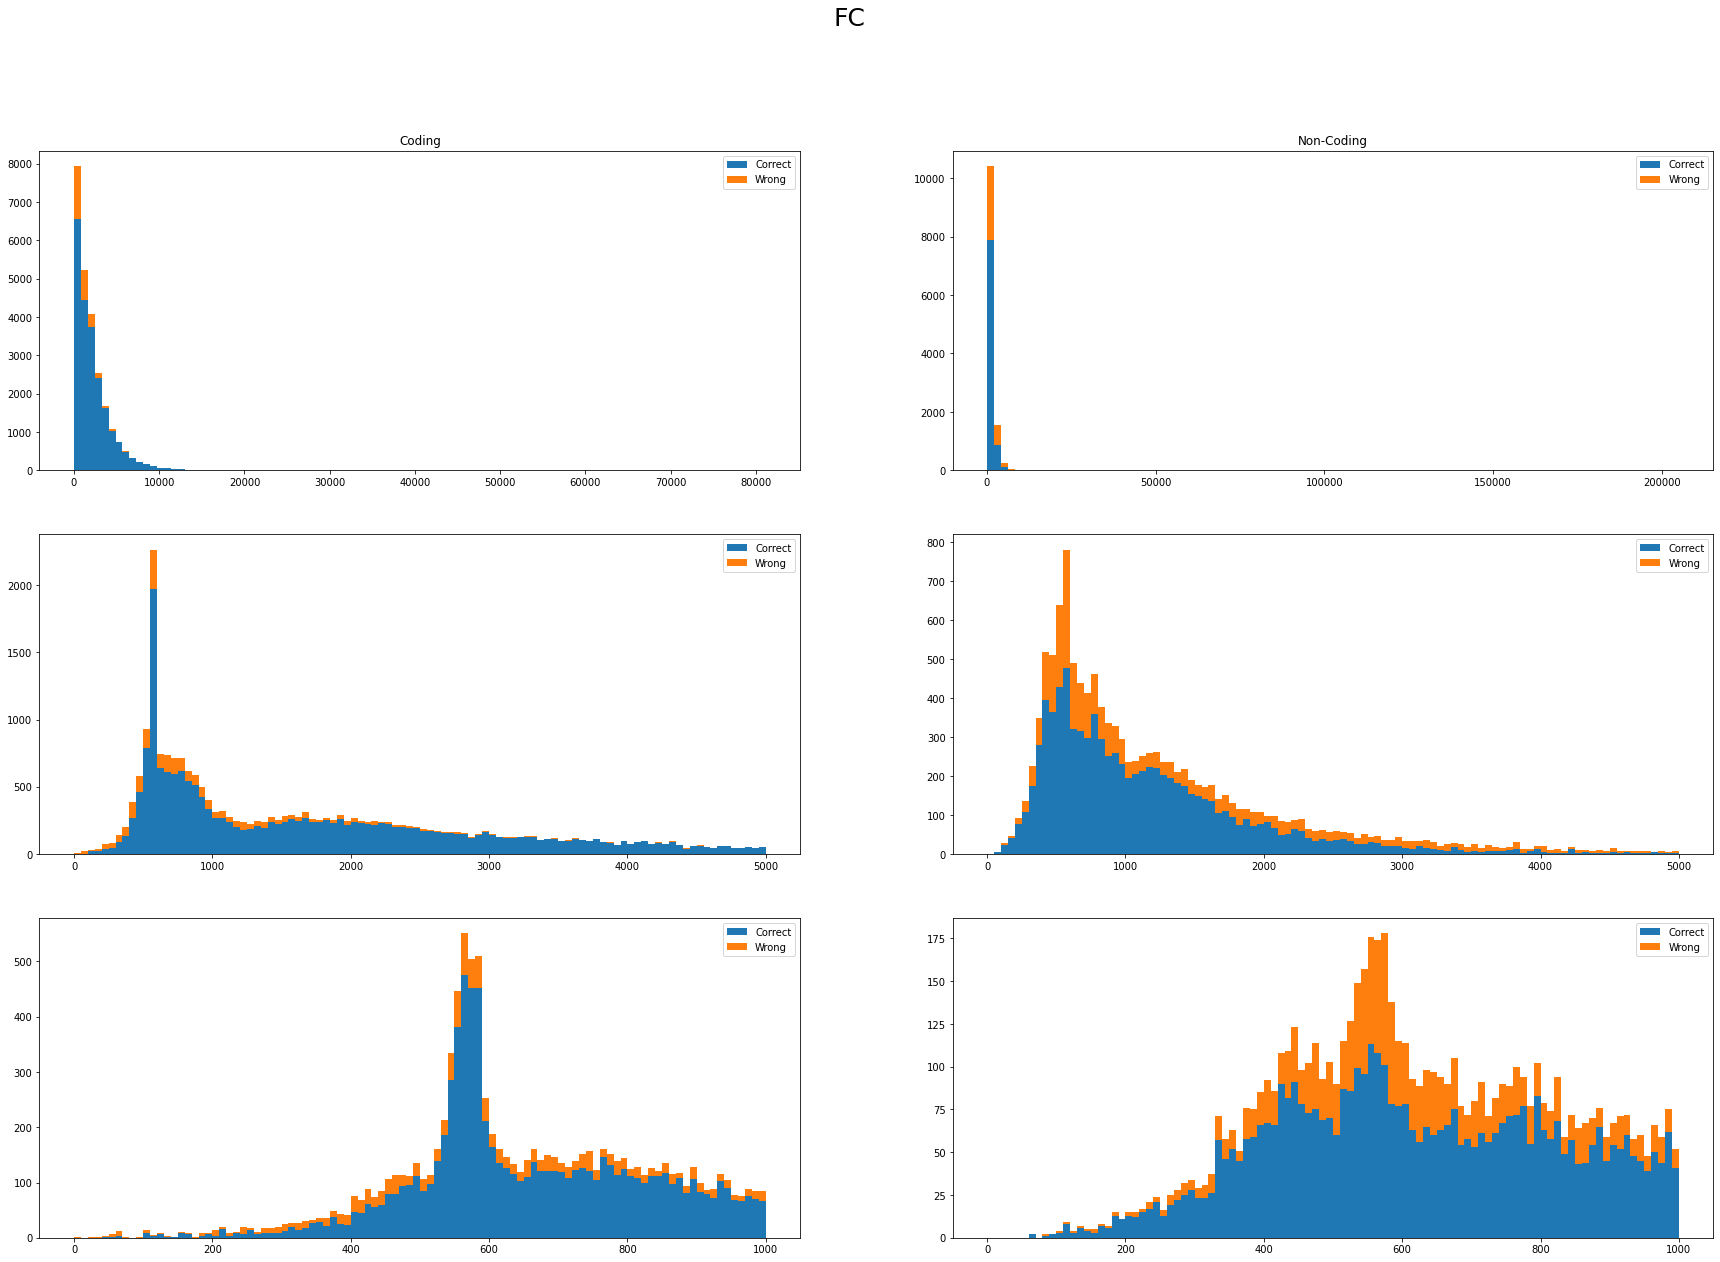

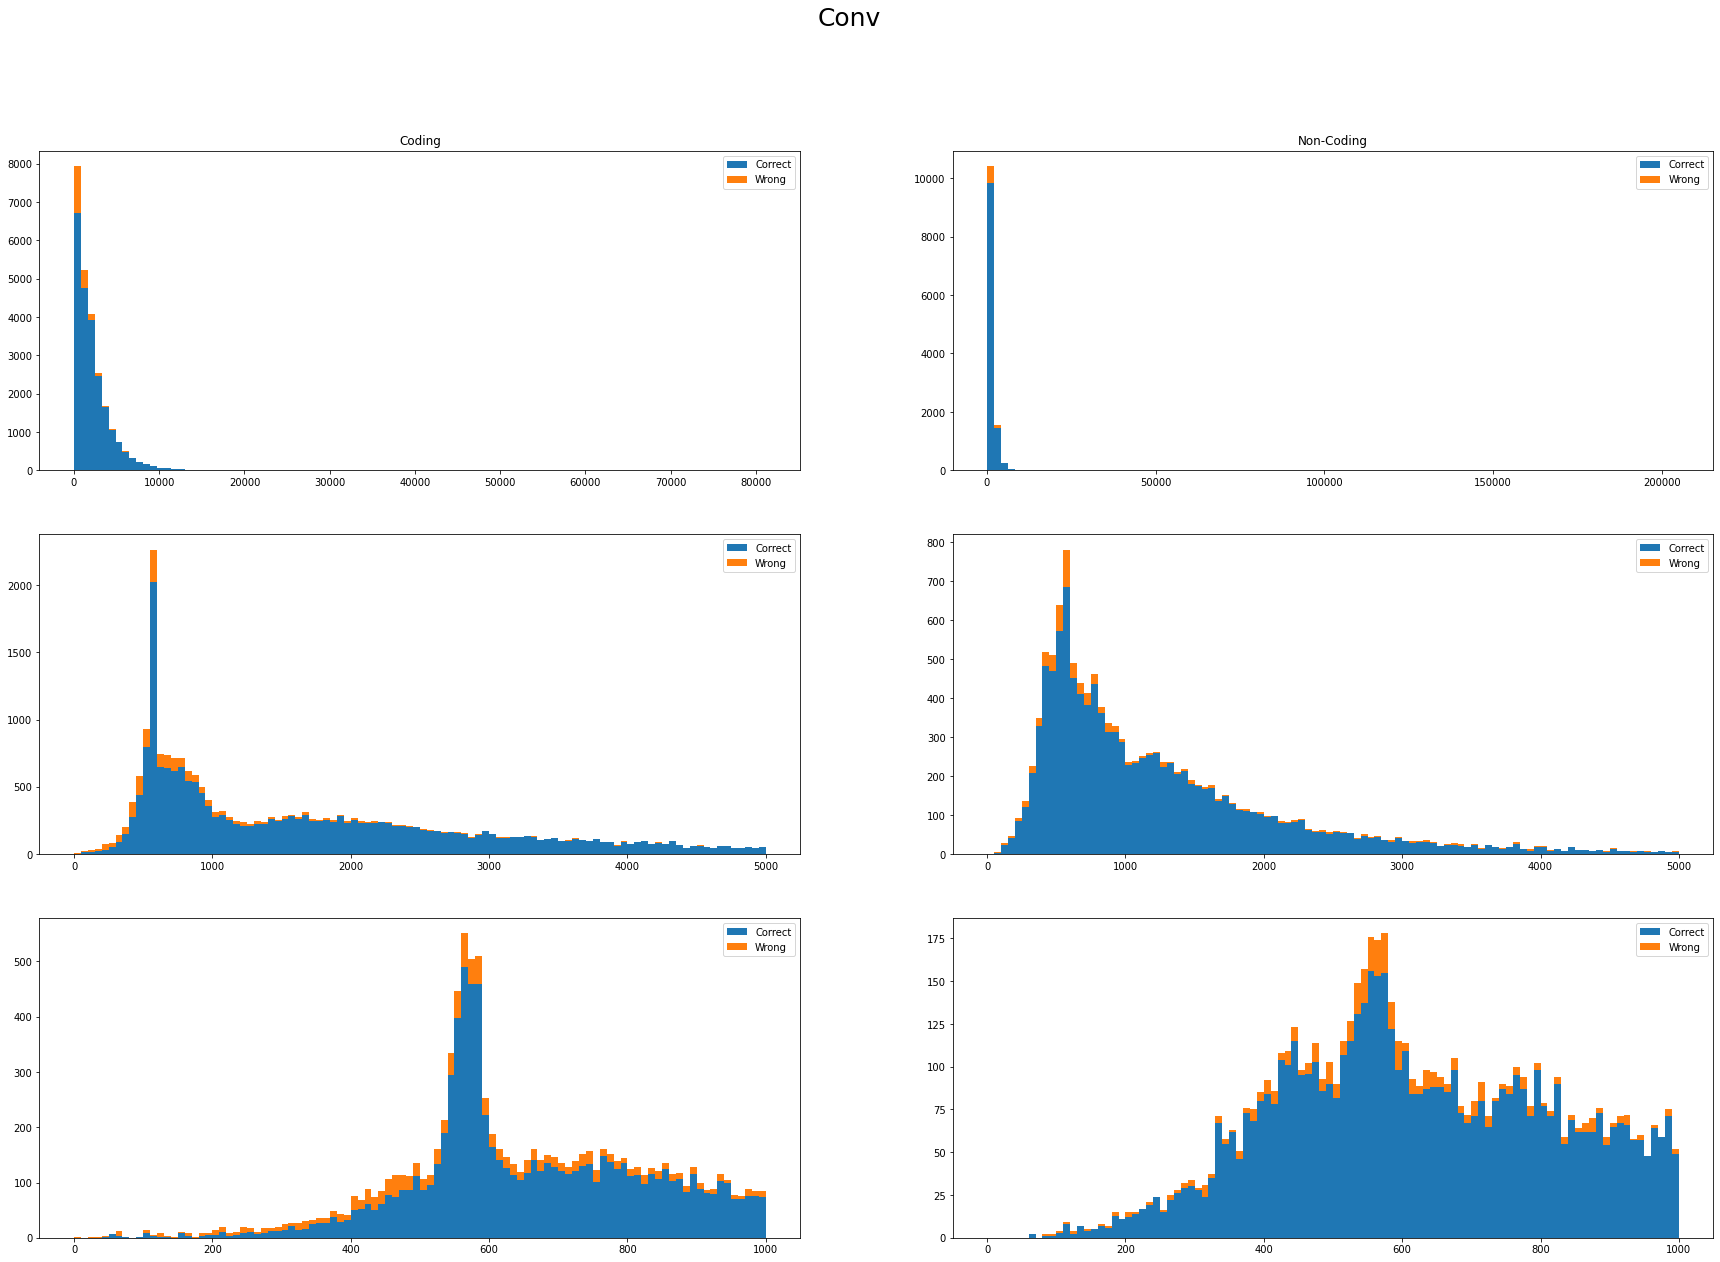

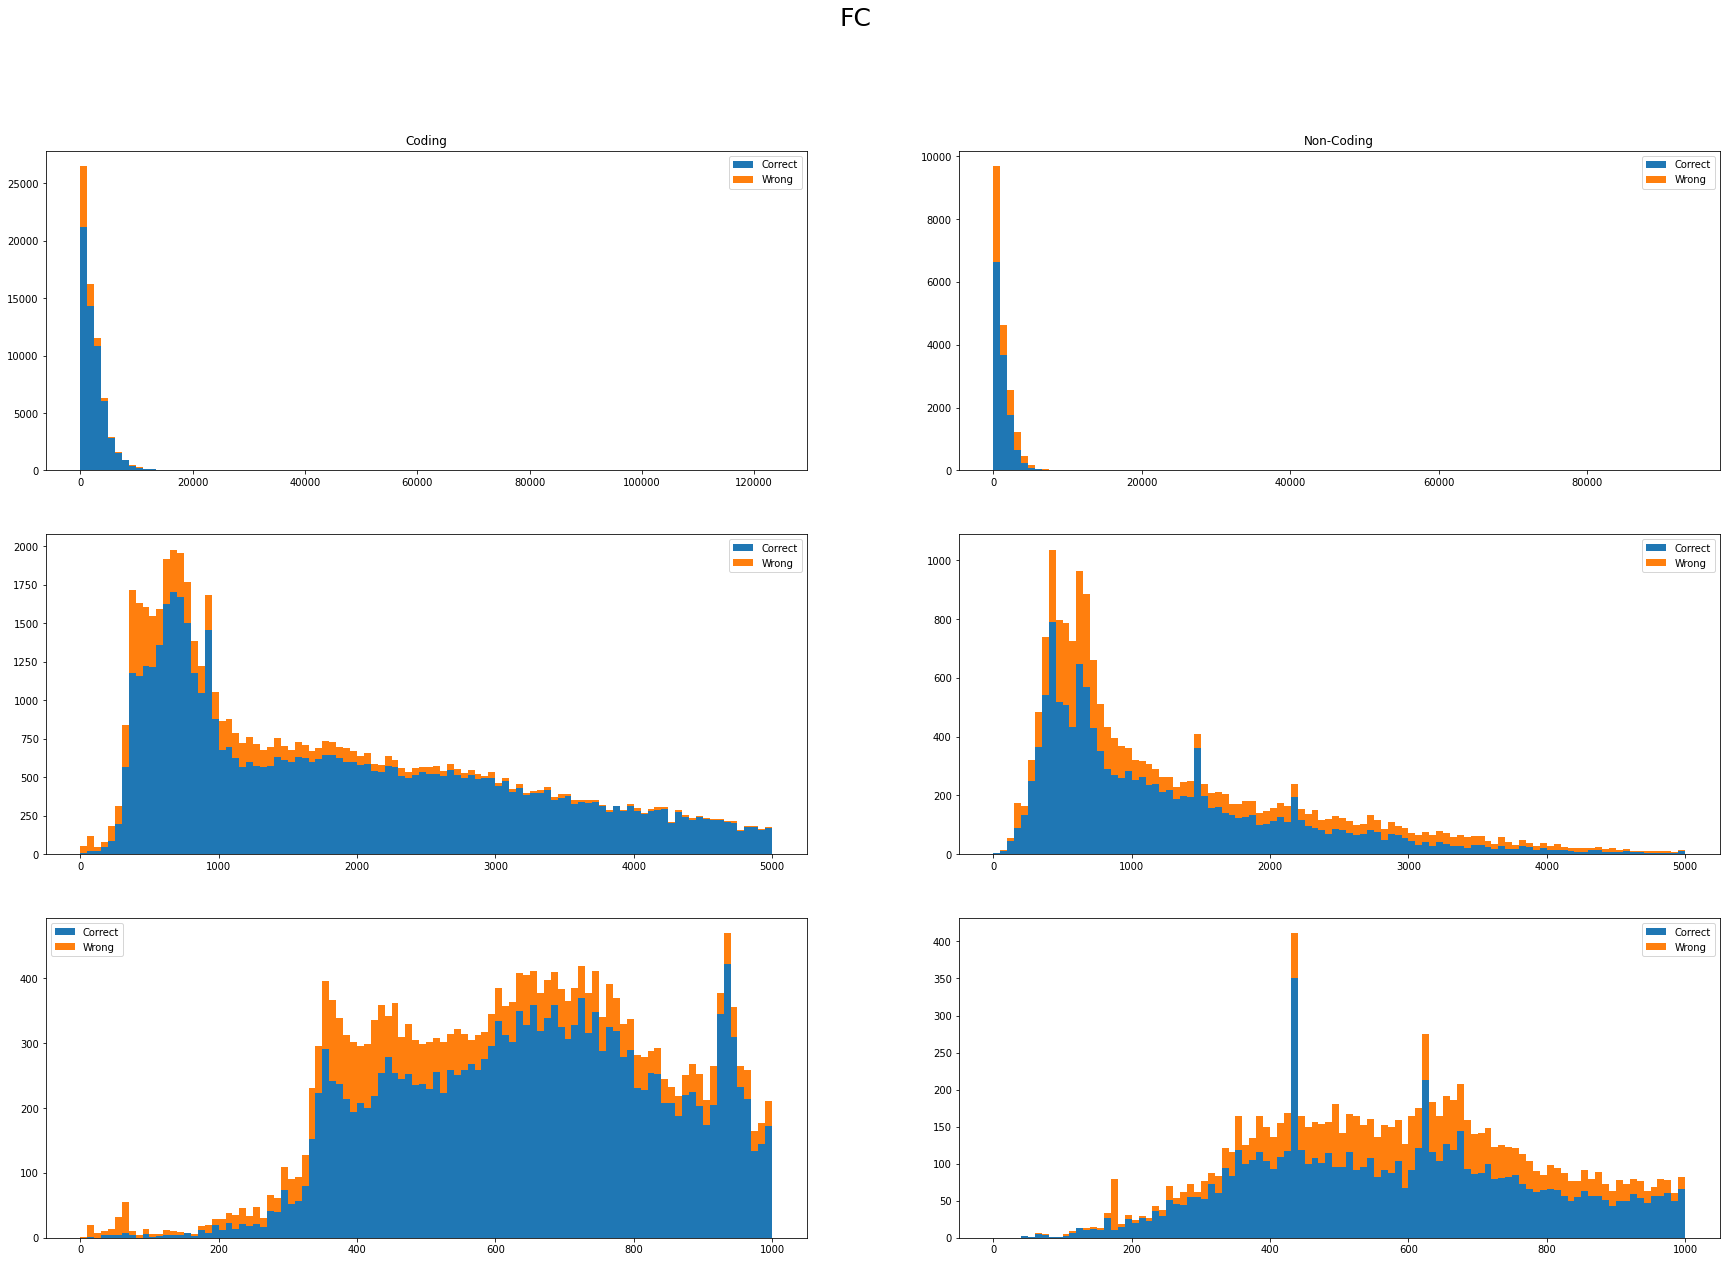

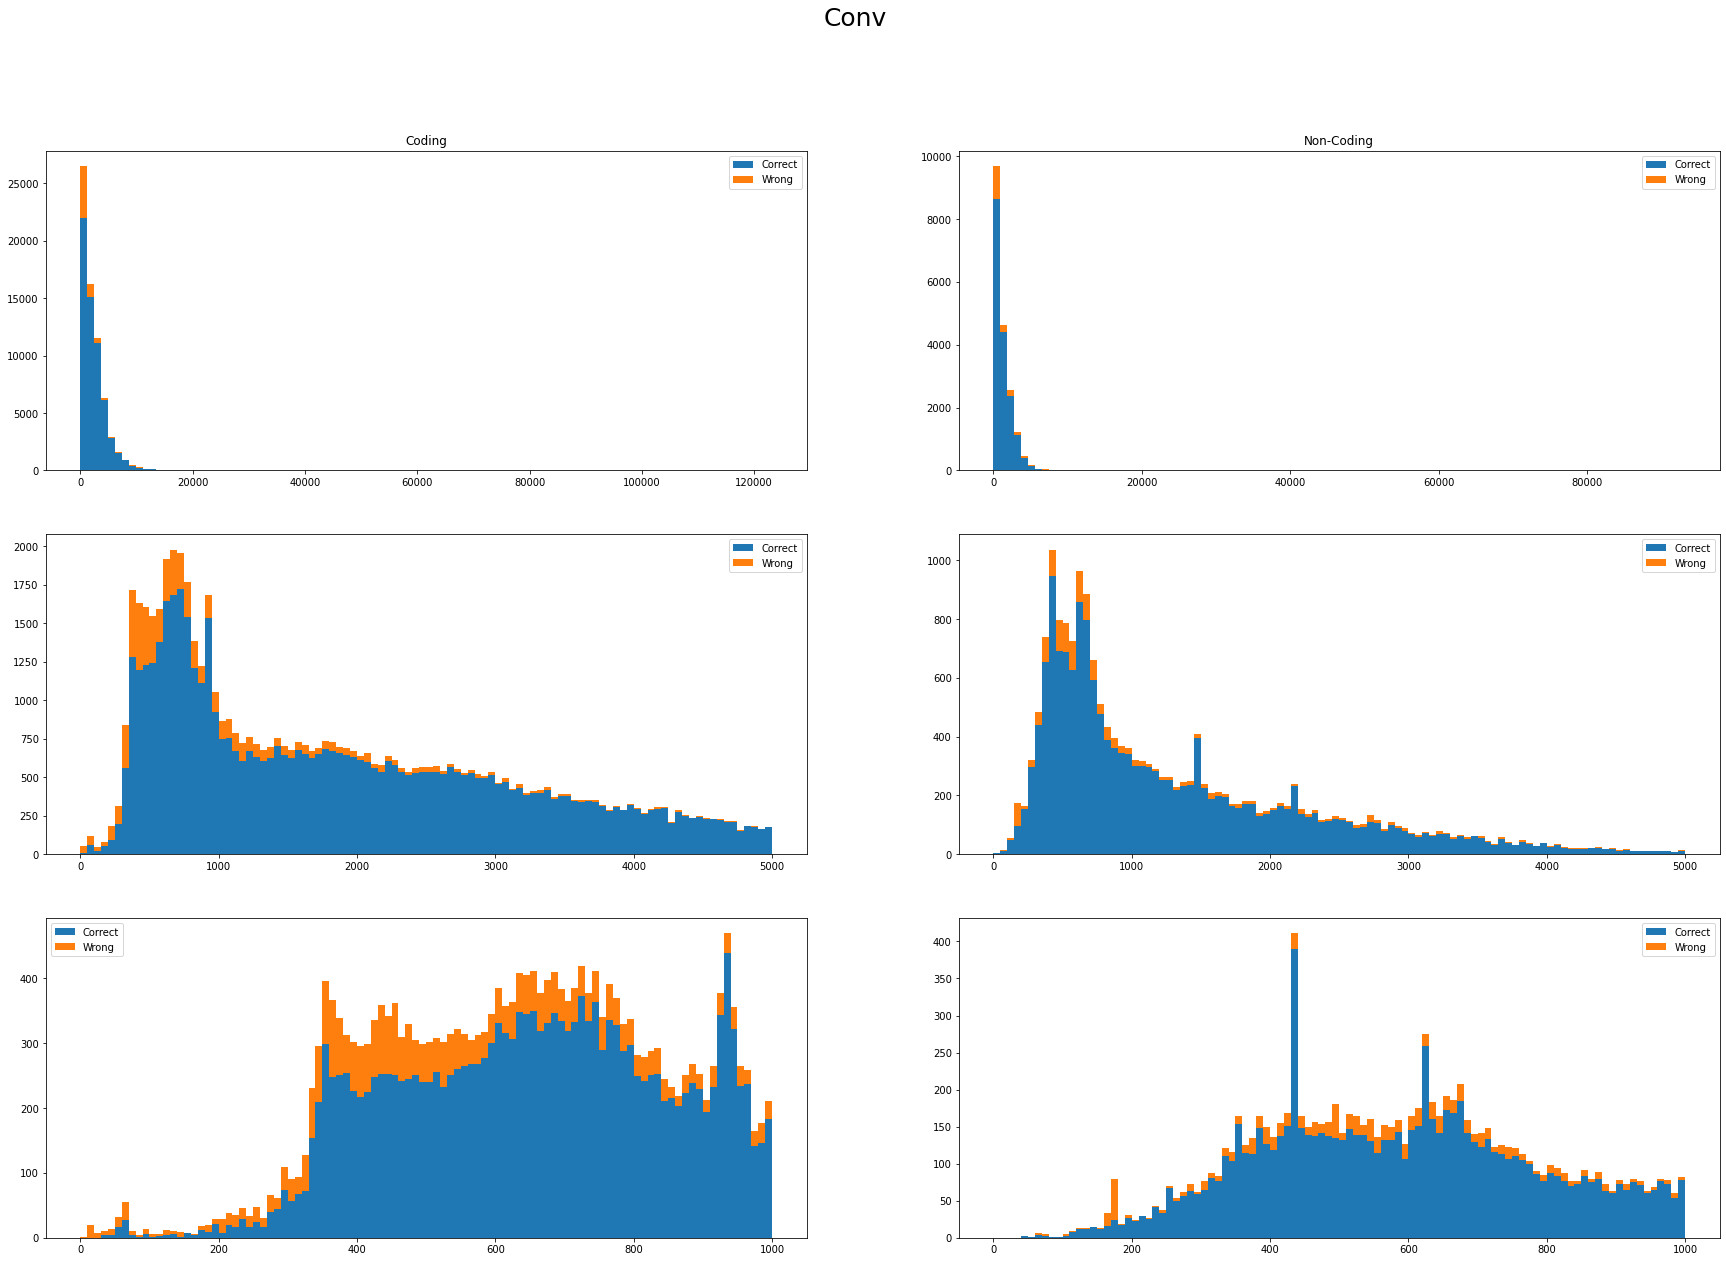

In [19]:
def plot_test(X, y, y_pred, title):
  y_coding_mask = y == 0
  y_non_coding_mask = y == 1

  coding_sizes = pd.Series(map(len, X[y_coding_mask]))
  non_coding_sizes = pd.Series(map(len, X[y_non_coding_mask]))
  coding_sizes_stack = [coding_sizes[y_pred[y_coding_mask] == 0], coding_sizes[y_pred[y_coding_mask] == 1]]
  non_coding_sizes_stack = [non_coding_sizes[y_pred[y_non_coding_mask] == 1], non_coding_sizes[y_pred[y_non_coding_mask] == 0]]

  labels = ['Correct', 'Wrong']

  fig, axs = plt.subplots(3, 2, figsize=(30, 20))
  plt.suptitle(title, fontsize=25)
  axs[0][0].hist(coding_sizes_stack, bins=100, stacked=True, label=labels)
  axs[0][0].set_title("Coding")
  axs[0][1].hist(non_coding_sizes_stack, bins=100, stacked=True, label=labels)
  axs[0][1].set_title("Non-Coding")
  axs[1][0].hist(coding_sizes_stack, bins=100, stacked=True, range=(0, 5e3), label=labels)
  axs[1][1].hist(non_coding_sizes_stack, bins=100, stacked=True, range=(0, 5e3), label=labels)
  axs[2][0].hist(coding_sizes_stack, bins=100, stacked=True, range=(0, 1e3), label=labels)
  axs[2][1].hist(non_coding_sizes_stack, bins=100, stacked=True, range=(0, 1e3), label=labels)
  for ax in axs.flat:
    ax.legend()
  plt.show()

display(HTML("<h3>Human</h3>"))
plot_test(X_test, y_test, y_fc_pred, "FC")
plot_test(X_test, y_test, y_conv_pred, "Conv")

display(HTML("<h3>Mouse</h3>"))
plot_test(m_data['seq'], m_data['class'], mouse_fc_pred, "FC")
plot_test(m_data['seq'], m_data['class'], mouse_conv_pred, "Conv")